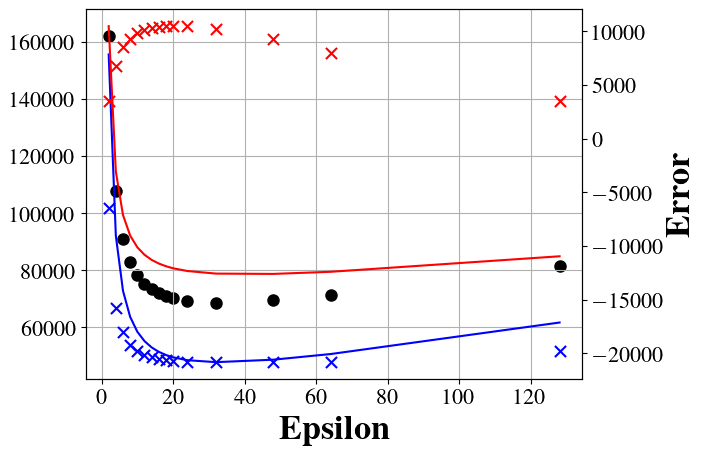

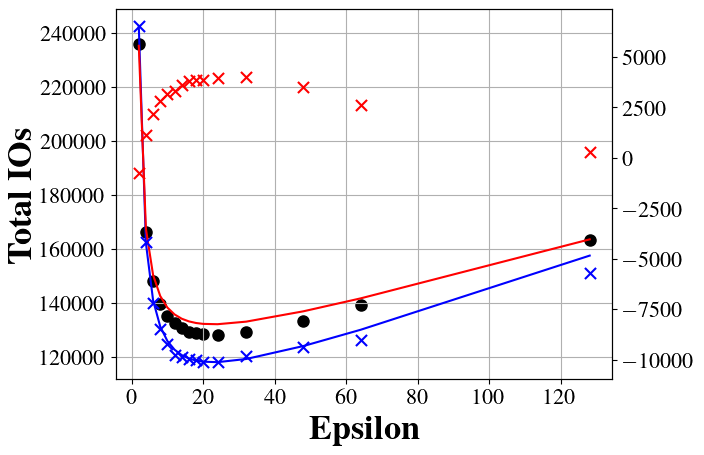

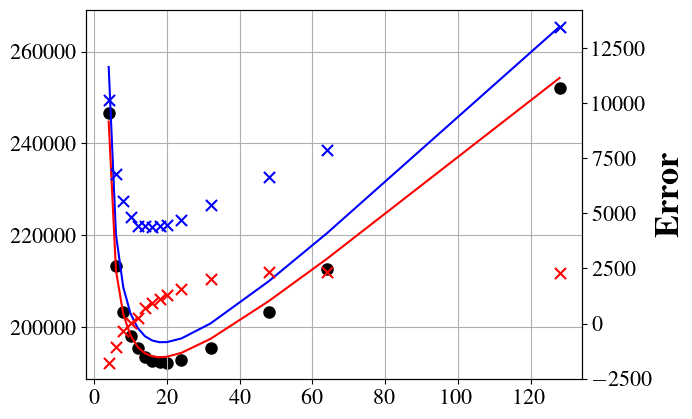

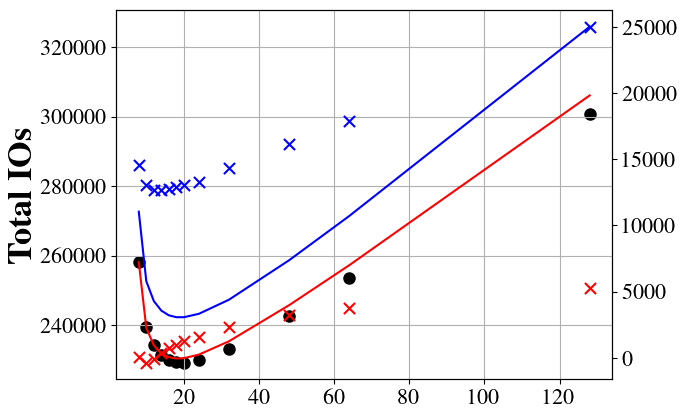

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from matplotlib.lines import Line2D
import numpy as np

DEBUG = False
LOG_PATH = "/mnt/home/zwshi/learned-index/cost-model/visualize/data/log/"
plt.rcParams.update({
                "text.usetex": True,
                "font.family": "serif",
                "font.serif": ["Times", "Computer Modern Roman"],
                "axes.unicode_minus": False,
                "text.latex.preamble": r"\usepackage{amsmath}",
            })

def load_data(file_path,max_eps=128):
    df = pd.read_csv(file_path)
    grouped = df.groupby('epsilon', as_index=False)['avg_IOs'].mean()
    grouped = grouped.rename(columns={'avg_IOs': 'real'})
    grouped = grouped[grouped["epsilon"]<=max_eps] 
    return grouped

def load_log(log_file_path, M=20, query_nums=1e6, max_eps=128):
    df = pd.read_csv(log_file_path)
    df = df[df['M'] == M]
    grouped = df.groupby('epsilon', as_index=False)['cost'].mean()
    grouped['expected'] = grouped['cost'] * query_nums
    grouped = grouped[grouped["epsilon"] <= max_eps]
    return grouped[['epsilon', 'expected']] 

def prepare_merged(file_path, log_file_path, M=20, query_nums=1e6):
    real_df = load_data(file_path)
    # print(real_df)
    exp_df  = load_log(log_file_path, M, query_nums)
    # print(exp_df)
    merged = pd.merge(real_df, exp_df, on='epsilon', how='inner').sort_values('epsilon')
    # merged['rel_err'] = (merged['expected'] - merged['real']) / merged['real']
    merged['rel_err'] = (merged['expected'] - merged['real'])
    return merged

# === 新增：预计算全局 y 轴范围（左轴：IO；右轴：相对误差%）===
def compute_global_limits(tasks, log_file_path, query_nums=1e6, max_eps=64, pad_ratio=0.05):
    """
    tasks: [(csv_path, M), (csv_path, M), ...]
    返回： (y_io_min, y_io_max), (y_err_min_pct, y_err_max_pct)
    """
    io_min, io_max = float('inf'), float('-inf')
    err_min, err_max = float('inf'), float('-inf')
    for csv_path, M in tasks:
        merged = prepare_merged(csv_path, log_file_path, M, query_nums)
        if len(merged)==0: 
            continue
        # 左轴：真实/预测 IO
        cur_min = min(merged['real'].min(), merged['expected'].min())
        cur_max = max(merged['real'].max(), merged['expected'].max())
        io_min = min(io_min, cur_min)
        io_max = max(io_max, cur_max)
        # 右轴：相对误差（转百分比）
        cur_e_min = (merged['rel_err']*100).min()
        cur_e_max = (merged['rel_err']*100).max()
        err_min = min(err_min, cur_e_min)
        err_max = max(err_max, cur_e_max)
    # 加一点边距，避免顶边
    io_pad  = (io_max-io_min)*pad_ratio if np.isfinite(io_min) and np.isfinite(io_max) else 0
    err_pad = (err_max-err_min)*pad_ratio if np.isfinite(err_min) and np.isfinite(err_max) else 0
    return (io_min-io_pad, io_max+io_pad), (err_min-err_pad, err_max+err_pad)

def plot_data(file_path, log_file_path, revision_log_path, M=20, query_nums=1e6,
              y_io_lim=None, y_err_lim_pct=None):
    query_nums = query_nums * 0.7   # 70% evaluation
    merged = prepare_merged(file_path, log_file_path, M, query_nums)
    if DEBUG:
        merged["rel_err"] = merged["rel_err"] / merged['real']
        print("ori:")
        print(merged)
    revi = prepare_merged(file_path, revision_log_path, M, query_nums)
    if DEBUG:
        revi["rel_err"] = revi["rel_err"] / revi['real']
        print("revi:")
        print(revi)
    fig, ax = plt.subplots()
    ax.scatter(merged['epsilon'], merged['real'], marker='o',
               label=r'\textbf{\Large{Real IOs}}', color="black")
    ax.plot(merged['epsilon'], merged['expected'], linestyle="-",
            label=r'\textbf{\Large{Estimated IOs}}', color="blue")
    ax.plot(revi['epsilon'], revi['expected'], linestyle="-",
            label=r'\textbf{\Large{Revised Estimated IOs}}', color="red")
    if M==40 or M==60:
        ax.set_xlabel(r'\textbf{\Huge{Epsilon}}')
    if M==10 or M==40:
        ax.set_ylabel(r'\textbf{\Huge{Total IOs}}')
    ax.grid(True)

    if y_io_lim is not None:
        ax.set_ylim(*y_io_lim)

    ax2 = ax.twinx()
    ax2.scatter(merged['epsilon'], merged['rel_err'],
                label=r'\textbf{\Large{Error}}', marker='x', color="blue")
    ax2.scatter(revi['epsilon'], revi['rel_err'],
                label=r'\textbf{\Large{Revised Error}}', marker='x', color="red")
    # ax2.yaxis.set_major_formatter(PercentFormatter())
    if M==20 or M==60:
        ax2.set_ylabel(r'\textbf{\Huge{Error}}')
    if y_err_lim_pct is not None:
        ax2.set_ylim(*y_err_lim_pct)

    # 合并图例
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    handles = lines + lines2
    labels = labels + labels2

    # 如果你不想在每幅图上显示 legend，可以把下面这行注释掉
    # ax.legend(handles, labels, loc='best')
    # plt.grid(True,'both',)
    plt.savefig(f"figs/books_{M}MB_IOs_prediction.pdf", dpi=300,
                bbox_inches='tight', pad_inches=0.1)
    plt.show()
    plt.close(fig)

    # 返回本图的 legend 信息
    return handles, labels

def save_legend_figure(handles, labels, filename="figs/IOs_prediction_legend.pdf"):
    # 这里可以按需要调节 figsize 和列数 ncol
    fig_legend = plt.figure(figsize=(8, 1.8))
    # frameon=False 去掉边框，方便丢到 Overleaf 里排版
    fig_legend.legend(handles, labels, loc='center', ncol=3, frameon=False, fontsize=18)
    fig_legend.savefig(filename, bbox_inches='tight', pad_inches=0)
    plt.close(fig_legend)

# ===== 用法：先算全局范围，再按同一范围出图 =====
tasks = [
    ('books_10M_M40_falcon.csv', 40),
    ('books_10M_M20_falcon.csv', 20),
    ('books_10M_M10_falcon.csv', 10),
]
# y_io_lim, y_err_lim_pct = compute_global_limits(tasks, LOG_PATH + 'books_10M_uint64_unique.query.log')

# plot_data('books_10M_M30_falcon.csv',LOG_PATH + 'books_10M_uint64_unique.query.log',
#           LOG_PATH + 'books_10M_uint64_unique_revision.query.log', 30)

handles, labels = plot_data('books_10M_M60_falcon.csv',LOG_PATH + 'books_10M_uint64_unique.query.log',
          LOG_PATH + 'books_10M_uint64_unique_revision.query.log', 60)

plot_data('books_10M_M40_falcon.csv',LOG_PATH + 'books_10M_uint64_unique.query.log',
          LOG_PATH + 'books_10M_uint64_unique_revision.query.log', 40)

plot_data('books_10M_M20_falcon.csv',LOG_PATH + 'books_10M_uint64_unique.query.log',
          LOG_PATH + 'books_10M_uint64_unique_revision.query.log', 20)

plot_data('books_10M_M10_falcon.csv',LOG_PATH + 'books_10M_uint64_unique.query.log',
          LOG_PATH + 'books_10M_uint64_unique_revision.query.log', 10)

save_legend_figure(handles, labels)




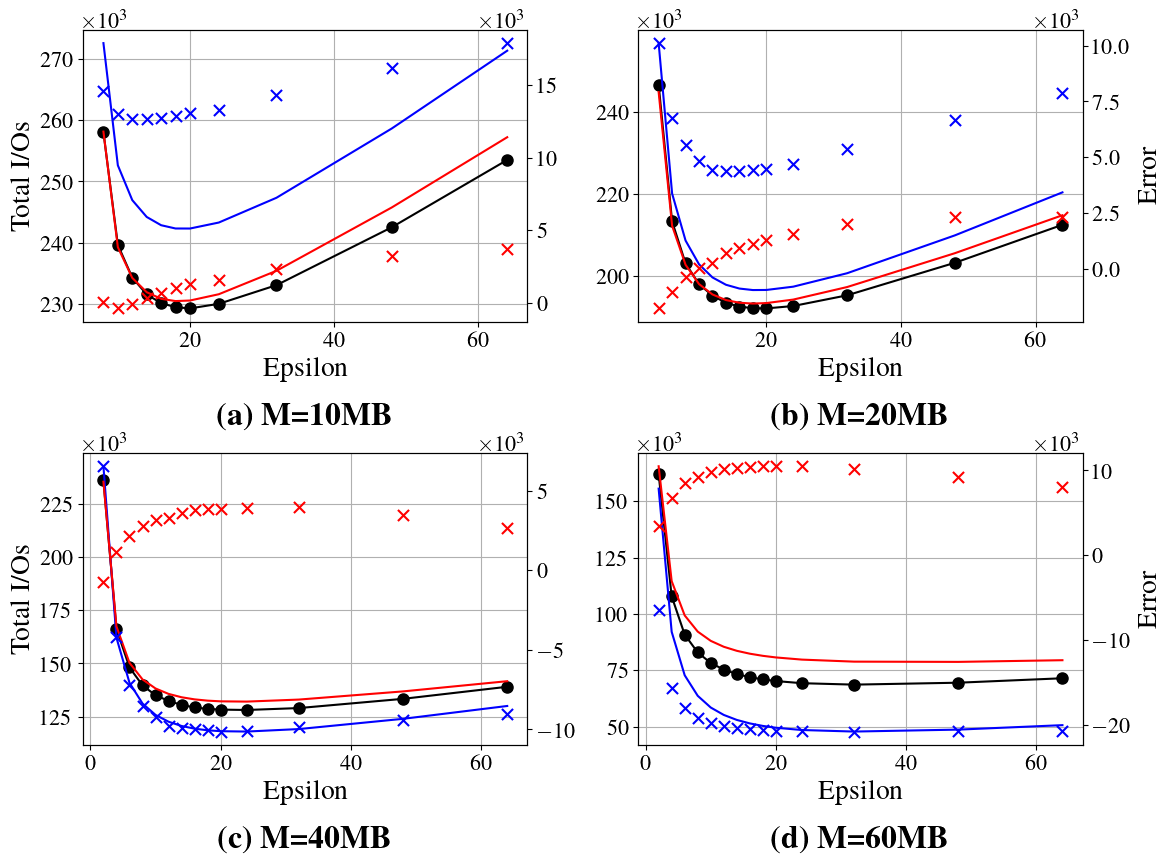

In [7]:
from matplotlib.ticker import PercentFormatter
from matplotlib.ticker import ScalarFormatter
plt.rcParams.update({
                "text.usetex": True,
                "font.family": "serif",
                "font.serif": ["Times", "Computer Modern Roman"],
                "axes.unicode_minus": False,
                "text.latex.preamble": r"\usepackage{amsmath}",
            })

def prepare_merged(file_path, log_file_path, M=20, query_nums=1e6, max_eps=128):
    real_df = load_data(file_path, max_eps=max_eps)
    exp_df  = load_log(log_file_path, M, query_nums, max_eps=max_eps)
    merged = pd.merge(real_df, exp_df, on='epsilon', how='inner').sort_values('epsilon')
    merged['abs_err'] = (merged['expected'] - merged['real'])
    return merged

def compute_global_limits(tasks, log_path, revision_log_path, query_nums=1e6, max_eps=64, pad_ratio=0.05):
    """
    tasks: [(csv_path, M), ...]
    统一所有子图的 y 范围：
      - 左轴：IO（real/expected/revised expected）
      - 右轴：相对误差比例（err = (expected-real)/real）
    """
    q_eval = query_nums * 0.7  # 和你 plot_data 对齐：70% evaluation

    io_min, io_max = float('inf'), float('-inf')
    err_min, err_max = float('inf'), float('-inf')

    for csv_path, M in tasks:
        merged = prepare_merged(csv_path, log_path, M, q_eval, max_eps=max_eps)
        revi   = prepare_merged(csv_path, revision_log_path, M, q_eval, max_eps=max_eps)
        if len(merged) == 0 or len(revi) == 0:
            continue

        # 左轴 IO 范围：real / expected / revised expected
        cur_min = min(merged['real'].min(), merged['expected'].min(), revi['expected'].min())
        cur_max = max(merged['real'].max(), merged['expected'].max(), revi['expected'].max())
        io_min = min(io_min, cur_min)
        io_max = max(io_max, cur_max)

        # 右轴相对误差：比例（非百分比）
        err = merged['abs_err'] / merged['real']
        rerr = revi['abs_err'] / revi['real']
        cur_e_min = min(err.min(), rerr.min())
        cur_e_max = max(err.max(), rerr.max())
        err_min = min(err_min, cur_e_min)
        err_max = max(err_max, cur_e_max)

    io_pad  = (io_max - io_min) * pad_ratio if np.isfinite(io_min) and np.isfinite(io_max) else 0
    err_pad = (err_max - err_min) * pad_ratio if np.isfinite(err_min) and np.isfinite(err_max) else 0
    return (io_min - io_pad, io_max + io_pad), (err_min - err_pad, err_max + err_pad)

def plot_one(ax, file_path, log_path, revision_log_path, M, query_nums=1e6,
             y_io_lim=None, y_err_lim=None, max_eps=64,
             show_xlabel=False, show_ylabel_left=False, show_ylabel_right=False,
             show_legend=False, panel_text=None):
    q_eval = query_nums * 0.7

    merged = prepare_merged(file_path, log_path, M, q_eval, max_eps=max_eps)
    revi   = prepare_merged(file_path, revision_log_path, M, q_eval, max_eps=max_eps)

    # 误差改成“相对误差比例”
    merged['rel_err'] = merged['abs_err'] / merged['real']
    revi['rel_err']   = revi['abs_err'] / revi['real']

    # --- 左轴：IO ---
    h_real, = ax.plot(merged['epsilon'], merged['real'], marker='o', color='black',
                        label=r'Real I/Os')
    h_est, = ax.plot(merged['epsilon'], merged['expected'], linestyle='-', color='blue',
                     label=r'Estimated I/Os')
    h_rev, = ax.plot(revi['epsilon'], revi['expected'], linestyle='-', color='red',
                     label=r'Calibrated Estimated I/Os')

    formatter = ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((3, 3))   # 强制使用 10^3
    ax.yaxis.set_major_formatter(formatter)

    ax.ticklabel_format(axis='y', style='sci', scilimits=(3, 3))

    ax.grid(True)

    if y_io_lim is not None:
        ax.set_ylim(*y_io_lim)

    if show_xlabel:
        ax.set_xlabel(r'Epsilon',fontsize=20)

    if show_ylabel_left:
        ax.set_ylabel(r'Total I/Os',fontsize=20)
    else:
        ax.set_ylabel("")
        # ax.tick_params(axis='y', labelleft=False)

    # --- 右轴：Error ---
    ax2 = ax.twinx()
    h_err = ax2.scatter(merged['epsilon'], merged['abs_err'], marker='x', color='blue',
                        label=r'Error')
    h_rerr = ax2.scatter(revi['epsilon'], revi['abs_err'], marker='x', color='red',
                         label=r'Calibrated Error')
    ax2.yaxis.set_major_formatter(formatter)
    ax2.ticklabel_format(axis='y', style='sci', scilimits=(3, 3))
    if y_err_lim is not None:
        ax2.set_ylim(*y_err_lim)

    if show_ylabel_right:
        ax2.set_ylabel(r'Error',fontsize=20)
        # 如果你想显示成百分号：0.07 -> 7%
        # ax2.yaxis.set_major_formatter(PercentFormatter(xmax=1.0))
    else:
        ax2.set_ylabel("")
        # ax2.tick_params(axis='y', labelright=False)

    # --- 面板标注 (a)(b)(c)(d) 放在底部 ---
    if panel_text is not None:
        ax.text(0.5, -0.28, panel_text, transform=ax.transAxes,
                ha='center', va='top', fontsize=23)

    # --- 统一 legend：只取一次 ---
    handles = [h_real, h_est, h_rev, h_err, h_rerr]
    labels  = [h.get_label() for h in handles]
    if show_legend:
        ax.legend(handles, labels, loc='upper right', frameon=False, fontsize=18)

    return handles, labels

def plot_2x2(tasks, log_path, revision_log_path, out_pdf,
             query_nums=1e6, max_eps=64):
    """
    tasks: [(csv_path, M, panel_text), ...]  # 长度=4
    """
    # 统一 y 轴范围
    # y_io_lim, y_err_lim = compute_global_limits(
    #     [(t[0], t[1]) for t in tasks],
    #     log_path, revision_log_path,
    #     query_nums=query_nums,
    #     max_eps=max_eps
    # )

    fig, axes = plt.subplots(2, 2, figsize=(12, 9))
    axes = axes.flatten()

    legend_handles, legend_labels = None, None

    for i, (ax, (csv_path, M, panel)) in enumerate(zip(axes, tasks)):
        r, c = divmod(i, 2)

        # show_xlabel = (r == 1)          # 只在底行显示 x label
        show_ylabel_left = (c == 0)     # 只在左列显示左 y label
        show_ylabel_right = (c == 1)    # 只在右列显示右 y label
        show_xlabel = True       # 只在底行显示 x label
        # show_ylabel_left = True    # 只在左列显示左 y label
        # show_ylabel_right = True   # 只在右列显示右 y label
        show_legend = False             # 子图里不放 legend（避免遮挡）

        handles, labels = plot_one(
            ax,
            csv_path,
            log_path,
            revision_log_path,
            M,
            query_nums=query_nums,
            # y_io_lim=y_io_lim,
            # y_err_lim=y_err_lim,
            max_eps=max_eps,
            show_xlabel=show_xlabel,
            show_ylabel_left=show_ylabel_left,
            show_ylabel_right=show_ylabel_right,
            show_legend=show_legend,
            panel_text=panel
        )

        if legend_handles is None:
            legend_handles, legend_labels = handles, labels

    fig.tight_layout()
    fig.subplots_adjust(
        hspace=0.45,   
        wspace=0.25    
    )
    fig.savefig(out_pdf, dpi=300, bbox_inches='tight', pad_inches=0.1)
    plt.show()
    plt.close(fig)

    # 单独导出 legend
    save_legend_figure(legend_handles, legend_labels, filename="figs/IOs_prediction_legend.pdf")


tasks_2x2 = [
    ('books_10M_M10_falcon.csv', 10, r'\textbf{(a) M=10MB}'),
    ('books_10M_M20_falcon.csv', 20, r'\textbf{(b) M=20MB}'),
    ('books_10M_M40_falcon.csv', 40, r'\textbf{(c) M=40MB}'),
    ('books_10M_M60_falcon.csv', 60, r'\textbf{(d) M=60MB}'),
]

plot_2x2(
    tasks_2x2,
    LOG_PATH + 'books_10M_uint64_unique.query.log',
    LOG_PATH + 'books_10M_uint64_unique_revision.query.log',
    out_pdf="figs/books_2x2_IOs_prediction.pdf",
    query_nums=1e6,
    max_eps=64
)


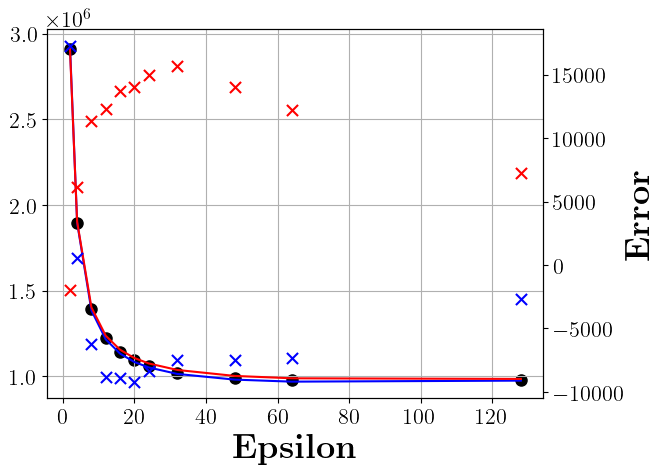

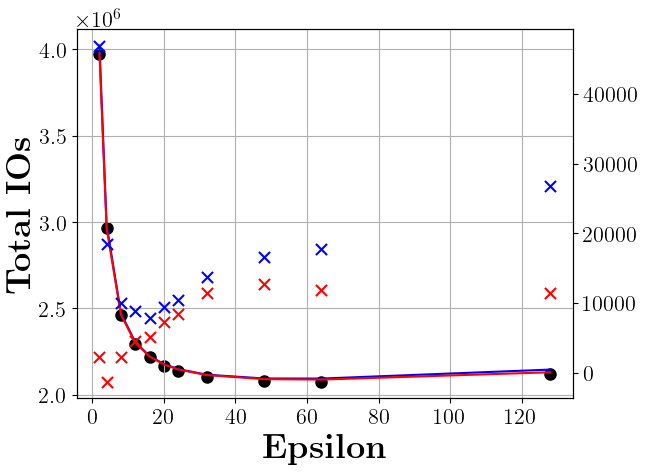

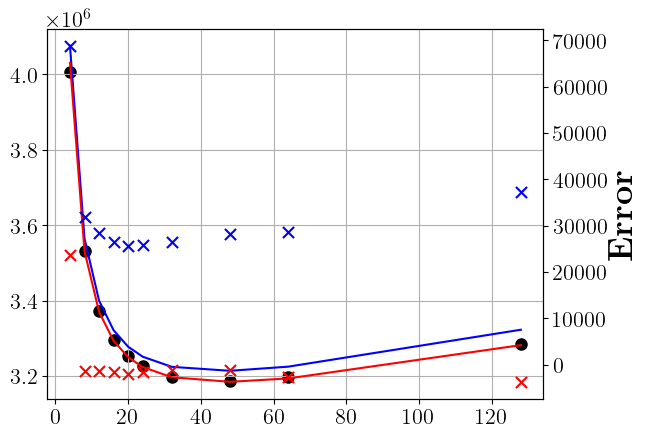

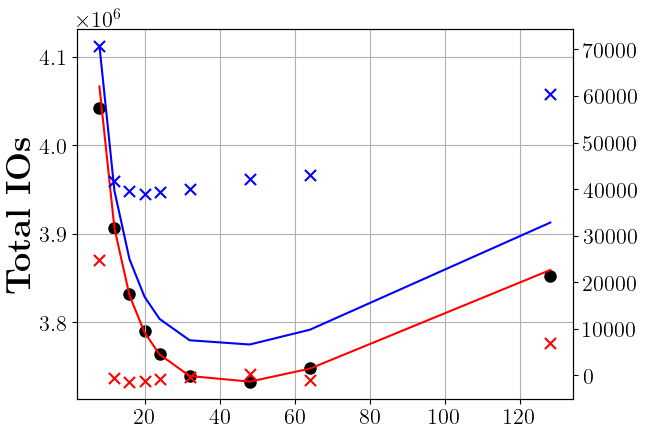

In [5]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern']
plt.rcParams['text.usetex'] = True
plt.rcParams['lines.markersize'] = 8 
plt.rcParams['font.size'] = 16

plot_data('range_fb_10M_M60.csv', LOG_PATH + 'fb_10M_uint64_unique.range.log',
          LOG_PATH + 'fb_10M_uint64_unique_revision.range.log',60)
plt.show()
plot_data('range_fb_10M_M40.csv', LOG_PATH + 'fb_10M_uint64_unique.range.log',
          LOG_PATH + 'fb_10M_uint64_unique_revision.range.log',40)
plt.show()
plot_data('range_fb_10M_M20.csv', LOG_PATH + 'fb_10M_uint64_unique.range.log',
          LOG_PATH + 'fb_10M_uint64_unique_revision.range.log',20)
plt.show()
plot_data('range_fb_10M_M10.csv', LOG_PATH + 'fb_10M_uint64_unique.range.log',
          LOG_PATH + 'fb_10M_uint64_unique_revision.range.log',10)
plt.show()

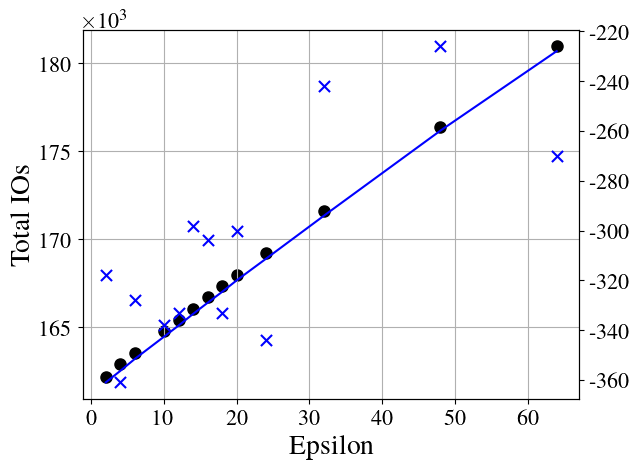

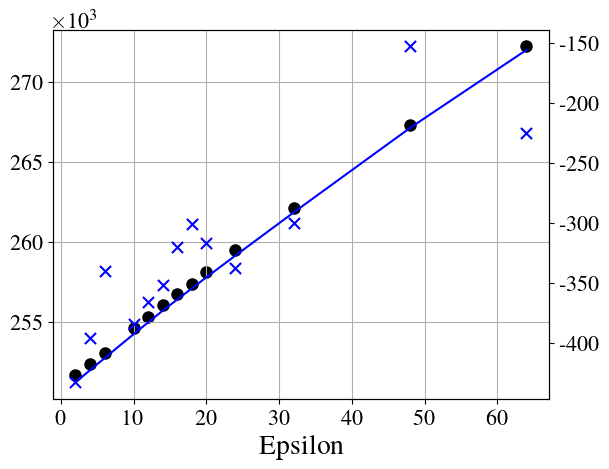

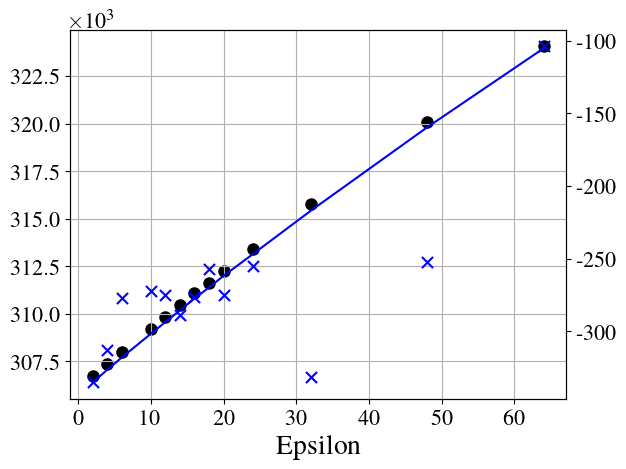

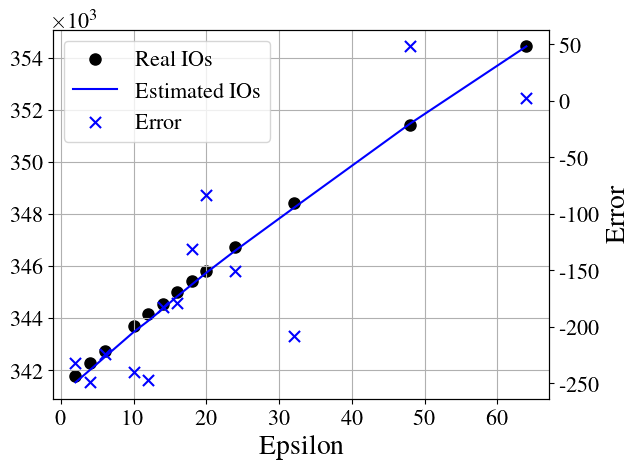

In [ ]:
from matplotlib.ticker import PercentFormatter
import matplotlib.ticker as mticker
from matplotlib.ticker import ScalarFormatter
# plt.rcParams['font.family'] = 'serif'
# plt.rcParams['font.serif'] = ['Computer Modern']
# plt.rcParams['text.usetex'] = True
# plt.rcParams['lines.markersize'] = 8 
# plt.rcParams['font.size'] = 16

plt.rcParams.update({
                "text.usetex": True,
                "font.family": "serif",
                "font.serif": ["Times", "Computer Modern Roman"],
                "axes.unicode_minus": False,
                "text.latex.preamble": r"\usepackage{amsmath}",
            })
def plot_data(file_path, log_file_path, revision_log_path, M=20, query_nums=1e6,
              y_io_lim=None, y_err_lim_pct=None):
    merged = prepare_merged(file_path, log_file_path, M, query_nums)
    revi = prepare_merged(file_path, revision_log_path, M, query_nums)

    fig, ax = plt.subplots()
    formatter = ScalarFormatter()
    formatter.set_powerlimits((3, 3))
    ax.yaxis.set_major_formatter(formatter)
    ax.ticklabel_format(axis='y', style='sci', scilimits=(3, 3))
    
    ax.scatter(merged['epsilon'], merged['real'], marker='o',
               label=r'Real IOs', color="black")
    ax.plot(merged['epsilon'], merged['expected'], linestyle="-",
            label=r'Estimated IOs', color="blue")
    # ax.plot(revi['epsilon'], revi['expected'], linestyle="-",
    #         label=r'\textbf{\Large{Revised Expected IOs}}', color="red")
    ax.set_xlabel(r'Epsilon',fontsize=20)
    if query_nums==1e6:
        ax.set_ylabel(r'Total IOs',fontsize=20)
    
    ax.grid(True)

    if y_io_lim is not None:
        ax.set_ylim(*y_io_lim)

    ax2 = ax.twinx()
    ax2.ticklabel_format(axis='y', style='plain', useOffset=False)
    # ax2.yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=4))
    ax2.scatter(merged['epsilon'], merged['abs_err'],
                label=r'Error', marker='x', color="blue")
    # ax2.scatter(revi['epsilon'], revi['rel_err'] * 1e6,
    #             label=r'\textbf{\Large{Revised Relative Error(ppm)}}', marker='x', color="red")
    # ax2.yaxis.set_major_formatter(PercentFormatter())
    ax2.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.0f'))
    if query_nums==4e6:
        ax2.set_ylabel(r'Error',fontsize=20)
        lines, labels = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        handles = lines + lines2
        labels = labels + labels2
        ax.legend(handles, labels, loc='best')
    if y_err_lim_pct is not None:
        ax2.set_ylim(*y_err_lim_pct)

    # 合并图例
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    handles = lines + lines2
    # labels = labels + labels2

    # 如果你不想在每幅图上显示 legend，可以把下面这行注释掉
    # ax.legend(handles, labels, loc='best')

    plt.savefig(f"figs/books_256MB_{int(query_nums/1e6)}Mq_IOs_prediction.pdf", dpi=300,
                bbox_inches='tight', pad_inches=0)
    plt.show()
    plt.close(fig)

    # 返回本图的 legend 信息
    return handles, labels

handles,labels = plot_data('books-200M-1Mq-join.csv', LOG_PATH + 'books_200M_uint64_unique.1Mtable2.join.log',
          LOG_PATH + 'books_200M_uint64_unique_revision.1Mtable.join.log',256,query_nums=1e6)
plt.show()
plot_data('books-200M-2Mq-join.csv', LOG_PATH + 'books_200M_uint64_unique.2Mtable2.join.log',
          LOG_PATH + 'books_200M_uint64_unique_revision.2Mtable.join.log',256,query_nums=2e6)
plt.show()
plot_data('books-200M-3Mq-join.csv', LOG_PATH + 'books_200M_uint64_unique.3Mtable2.join.log',
          LOG_PATH + 'books_200M_uint64_unique_revision.3Mtable.join.log',256,query_nums=3e6)
plt.show()
plot_data('books-200M-4Mq-join.csv', LOG_PATH + 'books_200M_uint64_unique.4Mtable2.join.log',
          LOG_PATH + 'books_200M_uint64_unique_revision.4Mtable.join.log',256,query_nums=4e6)
plt.show()

# save_legend_figure(handles, labels)

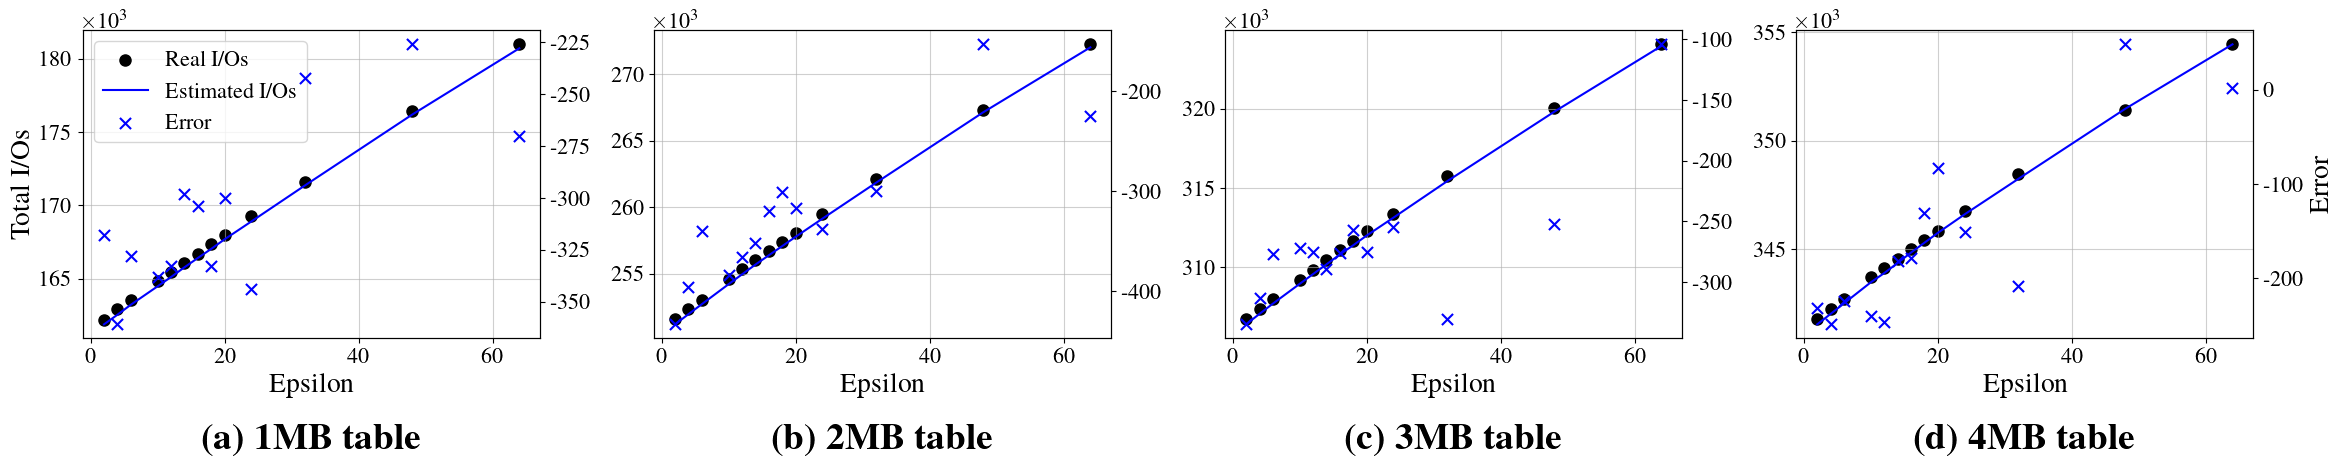

In [8]:
import matplotlib.ticker as mticker
from matplotlib.ticker import MultipleLocator, ScalarFormatter
plt.rcParams.update({
                "text.usetex": True,
                "font.family": "serif",
                "font.serif": ["Times", "Computer Modern Roman"],
                "axes.unicode_minus": False,
                "text.latex.preamble": r"\usepackage{amsmath}",
            })


def plot_one(ax, file_path, log_file_path, revision_log_path,
             M=20, query_nums=1e6,
             y_io_lim=None, y_io_ticks=None,
             y_err_lim=None, y_err_ticks=None,
             show_left_ylabel=False,
             show_right_ylabel=False,
             show_legend=False):

    merged = prepare_merged(file_path, log_file_path, M, query_nums)
    # revi = prepare_merged(file_path, revision_log_path, M, query_nums)  # 若暂时不用可注释

    # ---- Left y-axis: IOs ----
    formatter = ScalarFormatter()
    formatter.set_powerlimits((3, 3))
    ax.yaxis.set_major_formatter(formatter)
    ax.ticklabel_format(axis='y', style='sci', scilimits=(3, 3))
    ax.yaxis.set_major_locator(MultipleLocator(5000)) 
    s1 = ax.scatter(merged['epsilon'], merged['real'], marker='o',
                    label=r'Real I/Os', color="black")
    l1, = ax.plot(merged['epsilon'], merged['expected'], linestyle="-",
                  label=r'Estimated I/Os', color="blue")

    ax.set_xlabel(r'Epsilon', fontsize=20)

    # 关键：用空格占位，保证所有子图 bbox 一致
    if show_left_ylabel:
        ax.set_ylabel(r'Total I/Os', fontsize=20)
    else:
        ax.set_ylabel(' ')   # 占位，不显示实际标签
    ax.grid(True,alpha=0.6)

    if y_io_lim is not None:
        ax.set_ylim(*y_io_lim)
    if y_io_ticks is not None:
        ax.set_yticks(y_io_ticks)

    # ---- Right y-axis: Error ----
    ax2 = ax.twinx()
    ax2.ticklabel_format(axis='y', style='plain', useOffset=False)

    s2 = ax2.scatter(merged['epsilon'], merged['abs_err'],
                     label=r'Error', marker='x', color="blue")

    ax2.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.0f'))

    # 同样用空格占位，保证一致性
    if show_right_ylabel:
        ax2.set_ylabel(r'Error', fontsize=20)
    else:
        ax2.set_ylabel(' ')

    if y_err_lim is not None:
        ax2.set_ylim(*y_err_lim)
    if y_err_ticks is not None:
        ax2.set_yticks(y_err_ticks)

    # ---- Legend only on the last subplot (upper-left) ----
    if show_legend:
        # 合并两个轴的 handles
        h1, lab1 = ax.get_legend_handles_labels()
        h2, lab2 = ax2.get_legend_handles_labels()
        leg = ax.legend(h1 + h2, lab1 + lab2, loc='upper left', frameon=True)
        leg.set_zorder(1000)
    return ax, ax2

fig, axes = plt.subplots(1, 4, figsize=(28, 4), gridspec_kw={"wspace": 0.25})

# 每张图单独配置（示例：你按自己的数据范围填）
cfgs = [
    # dict(q=1e6,
    #      y_io_lim=(1.65e5, 3.1e6), y_io_ticks=[1e6, 2e6, 3e6],
    #      y_err_lim=(-2e4, 2e4), y_err_ticks=[-20000, 0, 20000]),
    # dict(q=2e6,
    #      y_io_lim=(1.8e6, 6.2e6), y_io_ticks=[2e6, 4e6, 6e6],
    #      y_err_lim=(-3e4, 3e4), y_err_ticks=[-30000, 0, 30000]),
    # dict(q=3e6,
    #      y_io_lim=(2.7e6, 9.3e6), y_io_ticks=[3e6, 6e6, 9e6],
    #      y_err_lim=(-4e4, 4e4), y_err_ticks=[-40000, 0, 40000]),
    # dict(q=4e6,
    #      y_io_lim=(3.6e6, 1.24e7), y_io_ticks=[4e6, 8e6, 12e6],
    #      y_err_lim=(-5e4, 5e4), y_err_ticks=[-50000, 0, 50000]),
    dict(q=1e6),dict(q=2e6),dict(q=3e6),dict(q=4e6)
]
subtitles = [
    r'\textbf{(a) 1MB table}',
    r'\textbf{(b) 2MB table}',
    r'\textbf{(c) 3MB table}',
    r'\textbf{(d) 4MB table}',
]

for i, c in enumerate(cfgs):
    qM = int(c["q"] / 1e6)

    plot_one(
        axes[i],
        f'books-200M-{qM}Mq-join.csv',
        LOG_PATH + f'books_200M_uint64_unique.{qM}Mtable2.join.log',
        LOG_PATH + f'books_200M_uint64_unique_revision.{qM}Mtable.join.log',
        M=256, query_nums=c["q"],
        # y_io_lim=c["y_io_lim"], y_io_ticks=c["y_io_ticks"],
        # y_err_lim=c["y_err_lim"], y_err_ticks=c["y_err_ticks"],
        show_left_ylabel=(i == 0),
        show_right_ylabel=(i == 3),
        show_legend=(i == 0)   # legend 放最后一张图左上角
    )
    axes[i].text(
        0.5, -0.28,                  # y < 0 → x-axis 下方
        subtitles[i],
        transform=axes[i].transAxes,
        ha='center',
        va='top',
        fontsize=27
    )
plt.savefig("figs/books_256MB_join_IO_prediction_1x4.pdf", dpi=300,
            bbox_inches='tight', pad_inches=0.02)
plt.show()
plt.close(fig)


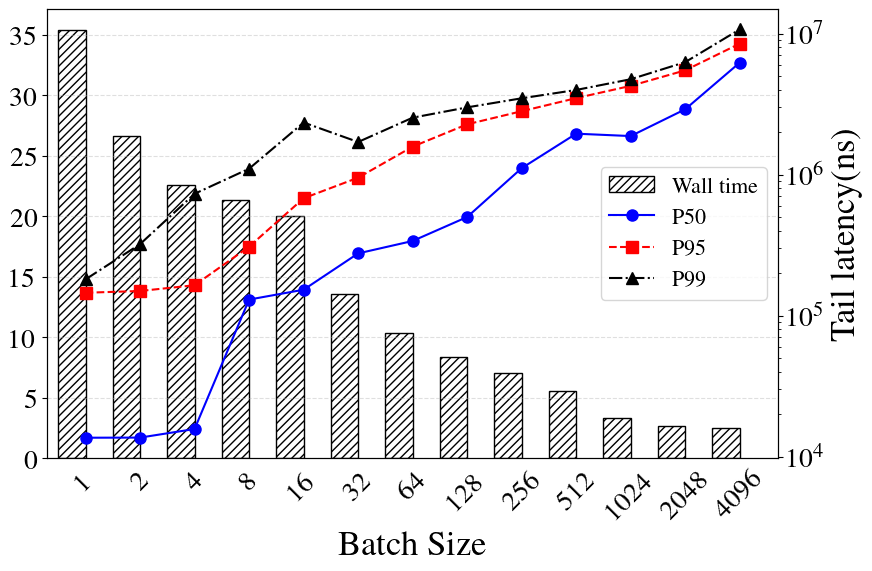

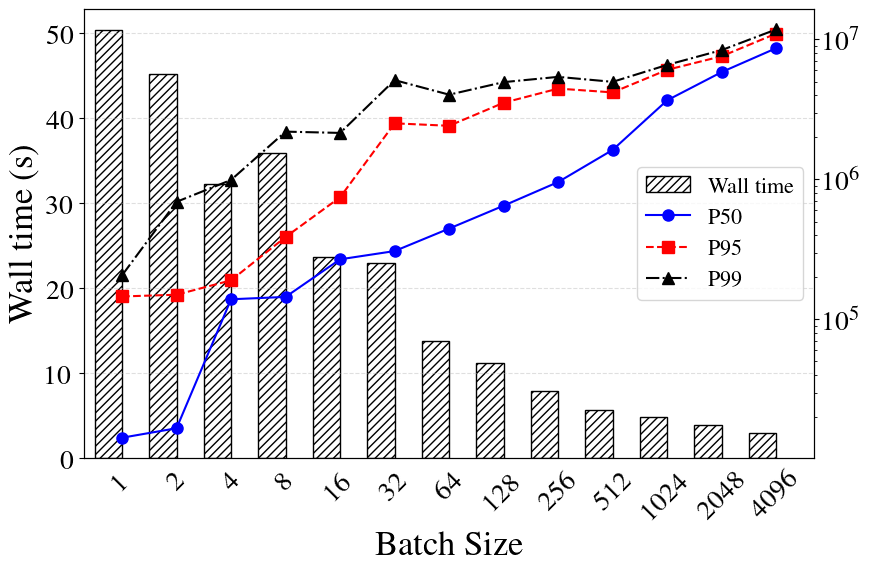

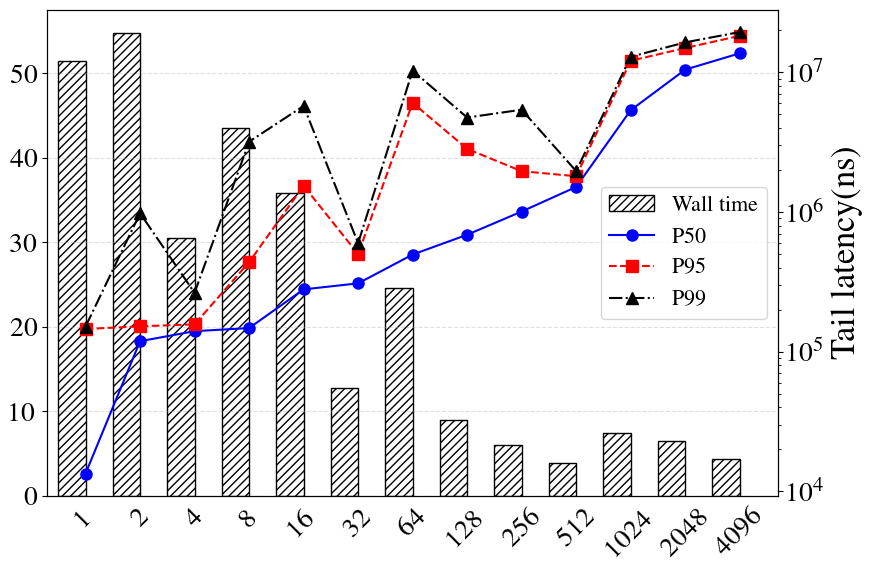

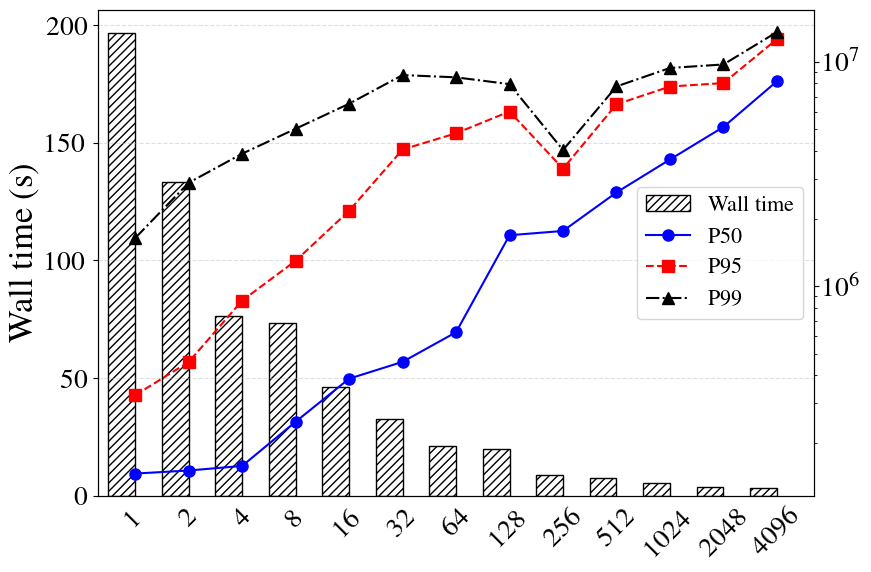

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

plt.rcParams.update({
                "text.usetex": True,
                "font.family": "serif",
                "font.serif": ["Times", "Computer Modern Roman"],
                "axes.unicode_minus": False,
                "text.latex.preamble": r"\usepackage{amsmath}",
            })

def load_data(file_path):
    df = pd.read_csv(file_path)
    grouped = df.groupby('batch', as_index=False).agg(
        avg_walltime_s=('avg_walltime_s', 'mean'),
        p50=('p50_ns', 'mean'),
        p95=('p95_ns', 'mean'),
        p99=('p99_ns', 'mean'),
    )
    grouped = grouped.sort_values('batch')
    return grouped

def plot_one_memory(file_path, mem_MB, out_prefix):
    data = load_data(file_path)

    fig, ax_left = plt.subplots(figsize=(9.0, 6.0))
    batch = data['batch'].values.astype(float)

    x = np.log2(batch)
    width = 0.5   

    bars = ax_left.bar(
        x - width / 2.0,      # 让柱子中心对齐到真实 batch 值
        data['avg_walltime_s'],
        width=width,
        color='none',         # 颜色样式你可以按论文风格再设计
        edgecolor='black',
        hatch='////',
        label='Wall time'
    )
    if mem_MB == 20 or mem_MB == 50:
        ax_left.set_xlabel(r'Batch Size',fontsize=25)
    if mem_MB == 0 or mem_MB == 20: 
        ax_left.set_ylabel(r'Wall time (s)',fontsize=25)
    # exps = np.log2(batch)
    # exps_rounded = np.round(exps).astype(int)
    # ax_left.set_xticks(exps_rounded)
    # ax_left.set_xticklabels(
    #     [rf'$2^{{{e}}}$' for e in exps_rounded]
    # )
    ax_left.set_xticks(range(len(batch)))
    ax_left.set_xticklabels([str(int(b)) for b in batch], fontsize=20, rotation=45)
    ax_left.set_xlim(-0.7, len(batch) - 0.3)
    ax_left.grid(True, axis='y', linestyle='--', alpha=0.4)

    # ---------- 右轴：tail latency 折线 ----------
    ax_right = ax_left.twinx()

    # 这里假定 p50/p95/p99 的单位和 magnitude 都差不多（比如秒或毫秒），
    # 如果是 ns，记得在 load_data 里先 /1e9 或在这里除。
    line_p50, = ax_right.plot(
        x, data['p50'],
        marker='o', linestyle='-', label='P50',
        color="blue",markersize=8
    )
    line_p95, = ax_right.plot(
        x, data['p95'],
        marker='s', linestyle='--', label='P95',
        color="red",markersize=8
    )
    line_p99, = ax_right.plot(
        x, data['p99'],
        marker='^', linestyle='-.', label='P99',
        color="black",markersize=8
    )
    if mem_MB == 10 or mem_MB == 50: 
        ax_right.set_ylabel(r'Tail latency(ns)',fontsize=25)
    # 如果跨度很大，可以打开下面这行用 log 轴
    ax_right.set_yscale('log',base=10)

    # ---------- 合并图例 ----------
    # 左轴只有一个 bar handle，右轴有 3 条线，把它们合到一起
    handles_left, labels_left = ax_left.get_legend_handles_labels()
    handles_right, labels_right = ax_right.get_legend_handles_labels()
    handles = handles_left + handles_right
    labels = labels_left + labels_right

    # ax_left.legend(handles, labels, loc='center left', bbox_to_anchor=(0.58, 0.35))
    ax_left.legend(handles, labels, loc='center right')

    # ax_left.set_title(rf'\textbf{{FALCON, Memory = {mem_MB}\,MB}}')
    ax_left.tick_params(axis='both', which='both', bottom=False, top=False, labelsize=20)
    ax_right.tick_params(axis='both', which='both', bottom=False, top=False, labelsize=20)
    fig.tight_layout()
    fig.savefig(f'figs/{out_prefix}_{mem_MB}MB.pdf', bbox_inches='tight', dpi=300)
    plt.show()
    plt.close(fig)

def plot_all_memories(file_paths, M_list):
    """
    file_paths: 每个 memory 对应一个 csv 文件
    M_list:     对应的 memory 大小 (MB)，例如 [20,10,0]
    """
    for file_path, mem_MB in zip(file_paths, M_list):
        # 输出文件前缀自己定一个
        plot_one_memory(file_path, mem_MB, out_prefix='batch_falcon_tail')

plot_all_memories(
    ['50M_batch_falcon.csv','20M_batch_falcon.csv','10M_batch_falcon.csv','0M_batch_falcon.csv'],
    [50, 20, 10, 0]
)


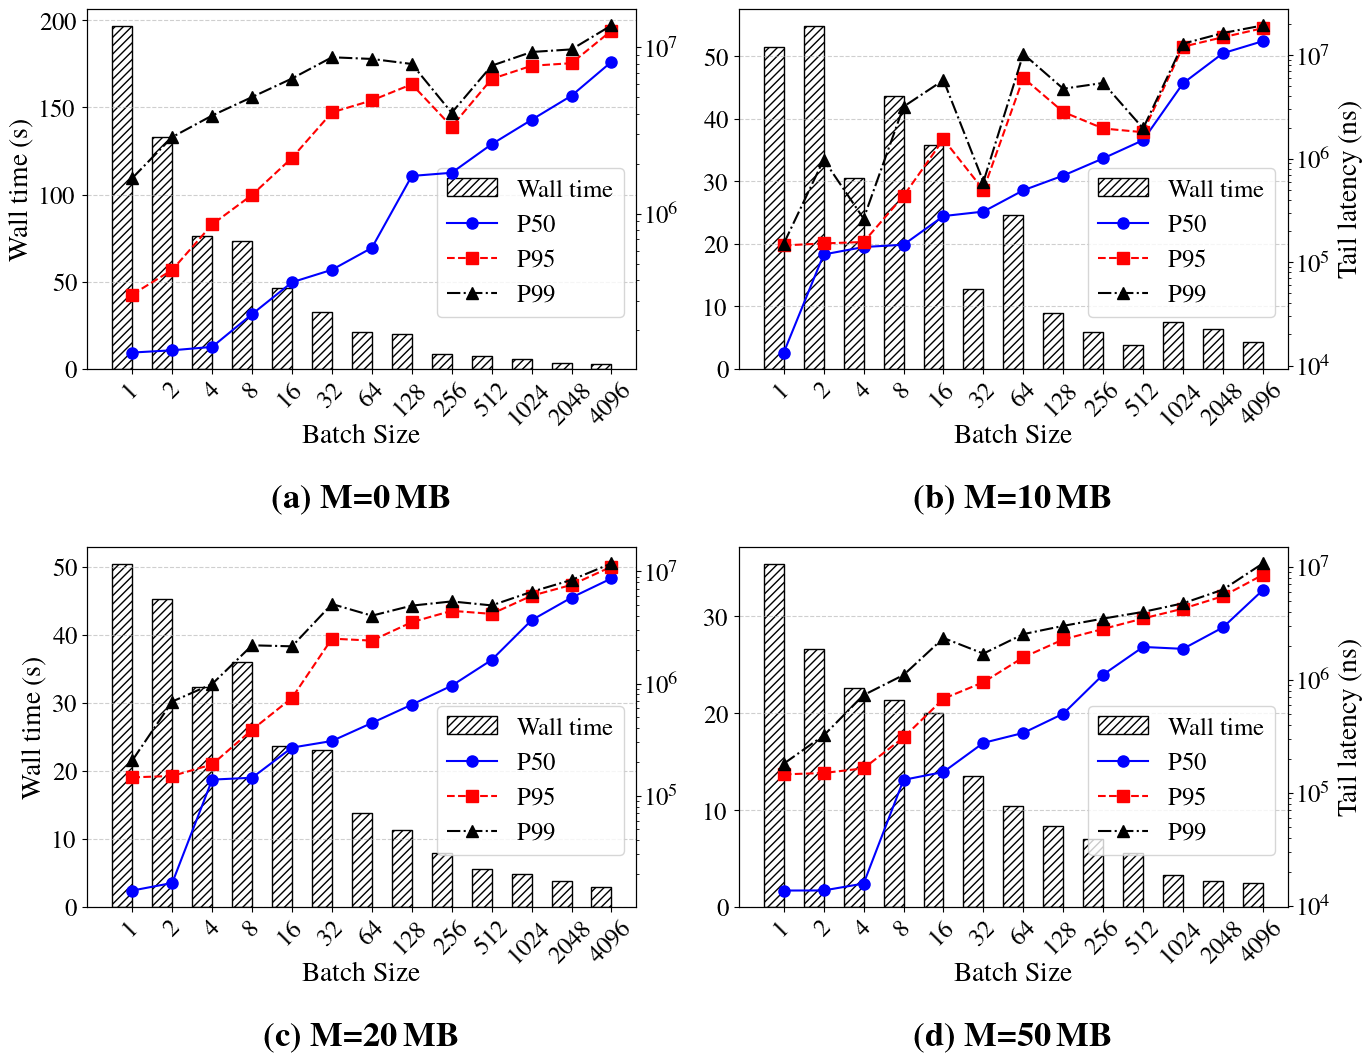

In [52]:

plt.rcParams.update({
                "text.usetex": True,
                "font.family": "serif",
                "font.serif": ["Times", "Computer Modern Roman"],
                "axes.unicode_minus": False,
                "text.latex.preamble": r"\usepackage{amsmath}",
            })
idx = 0
def plot_one_memory(ax_left, file_path, mem_MB, show_legend=False, i=0):
    global idx
    data = load_data(file_path)

    batch = data['batch'].values.astype(float)
    x = np.arange(len(batch))   # ★ 统一用 index，更适合 subplots
    width = 0.5

    # ---------- 左轴：wall time ----------
    bars = ax_left.bar(
        x - width / 2.0,
        data['avg_walltime_s'],
        width=width,
        color='none',
        edgecolor='black',
        hatch='////',
        label='Wall time'
    )

    ax_left.grid(True, axis='y', linestyle='--', alpha=0.6)
    ax_left.set_xticks(x)
    ax_left.set_xticklabels([str(int(b)) for b in batch], rotation=45)

    # ---------- 右轴：tail latency ----------
    ax_right = ax_left.twinx()

    line_p50, = ax_right.plot(
        x, data['p50'], marker='o', linestyle='-', label='P50', markersize=8, color='blue'
    )
    line_p95, = ax_right.plot(
        x, data['p95'], marker='s', linestyle='--', label='P95', markersize=8, color='red'
    )
    line_p99, = ax_right.plot(
        x, data['p99'], marker='^', linestyle='-.', label='P99', markersize=8, color='black'
    )

    ax_right.set_yscale('log', base=10)

    # ---------- 子图标题（底部 subtitle 风格） ----------
    pat = ["(a)", "(b)", "(c)", "(d)"]
    offset = -0.32
    formats = rf'{pat[idx]} M={mem_MB}\,MB'
    ax_left.text(
        0.5, offset,
        r'\textbf{'+formats+'}',
        transform=ax_left.transAxes,
        ha='center', va='top',
        fontsize=25
    )
    idx += 1
    
    if show_legend:
        handles_l, labels_l = ax_left.get_legend_handles_labels()
        handles_r, labels_r = ax_right.get_legend_handles_labels()
        ax_left.legend(
            handles_l + handles_r,
            labels_l + labels_r,
            loc='center right',
            bbox_to_anchor=(1.0, 0.35),
            fontsize=18,
            frameon=True
        )

    return ax_right


def plot_all_memories(file_paths, M_list):
    fig, axes = plt.subplots(
        2, 2,
        figsize=(14, 11),
        sharex=True
    )

    axes = axes.flatten()
    for ax in axes[:2]:   # 上面一行
        ax.tick_params(labelbottom=True)
    for i, (ax, file_path, mem_MB) in enumerate(zip(axes, file_paths, M_list)):
        show_legend = True # 只在右上角放 legend
        ax_right = plot_one_memory(ax, file_path, mem_MB, show_legend,i)

        # 左列：左 y 轴
        if i % 2 == 0:
            ax.set_ylabel(r'Wall time (s)', fontsize=20)
        else:
            # ax.set_yticklabels([])
            ax.set_ylabel("")

        # 右列：右 y 轴
        if i % 2 == 1:
            ax_right.set_ylabel(r'Tail latency (ns)', fontsize=20)
        else:
            ax_right.set_ylabel("")
            # ax_right.set_yticklabels([])

        # 只在底行显示 x label
        # if i >= 2:
        ax.set_xlabel(r'Batch Size', fontsize=20, labelpad=-5)

        ax.tick_params(labelsize=18)
        ax_right.tick_params(labelsize=18)

    fig.tight_layout()
    fig.savefig('figs/batch_falcon_all_memories.pdf', dpi=300, bbox_inches='tight')
    plt.show()

plot_all_memories(['0M_batch_falcon.csv','10M_batch_falcon.csv','20M_batch_falcon.csv','50M_batch_falcon.csv'],
    [0, 10, 20, 50])


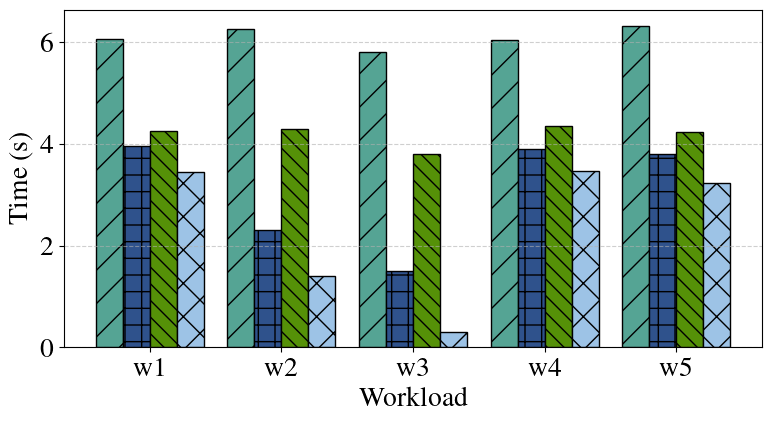

In [51]:
import os
import re
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


plt.rcParams.update({
                "text.usetex": True,
                "font.family": "serif",
                "font.serif": ["Times", "Computer Modern Roman"],
                "axes.unicode_minus": False,
                "text.latex.preamble": r"\usepackage{amsmath}",
            })
# ========== 配置 ==========
DATADIR = "/mnt/home/zwshi/learned-index/cost-model/include/FALCON/results/log"      
PREFIX  = "books-200M"         # 文件前缀：books-200M-point2.csv 等
CONFS   = [1, 2, 3, 4, 5]       # 你收集的 conf 编号
STRATS  = [
            "raw",
           "point", "range", "join"]  # 三种策略的顺序（也决定绘图顺序）

STYLE = [
         dict(facecolor="#55A494",hatch="/"),
         dict(facecolor="#2F528C",hatch="+"),
         dict(facecolor="#559108",hatch="\\\\"),
         dict(facecolor="#9DC3E6",hatch="x")]
# 兼容你当前三个文件里出现过的两种列名写法
WALLTIME_COL_CANDIDATES = [
    "total_wall_time_s",
]

def aggregate_walltime(series: pd.Series) -> float:
    return float(series.mean())

def find_walltime_col(df: pd.DataFrame) -> str:
    for c in WALLTIME_COL_CANDIDATES:
        if c in df.columns:
            return c
    # 更宽松兜底：匹配 total + wall + time + s
    for c in df.columns:
        if re.search(r"total.*wall.*time.*s", c, re.IGNORECASE):
            return c
    raise KeyError(f"Cannot find wall-time column in {list(df.columns)}")

def load_one(prefix: str, strat: str, n: int) -> float:
    path = os.path.join(DATADIR, f"{prefix}-{strat}{n}.csv")
    df = pd.read_csv(path)
    col = find_walltime_col(df)
    return aggregate_walltime(df[col])

# ========== 收集数据：shape = (len(CONFS), len(STRATS)) ==========
data = np.full((len(CONFS), len(STRATS)), np.nan, dtype=float)

missing = []
for i, n in enumerate(CONFS):
    for j, strat in enumerate(STRATS):
        path = os.path.join(DATADIR, f"{PREFIX}-{strat}{n}.csv")
        if not os.path.exists(path):
            missing.append(path)
            continue
        data[i, j] = load_one(PREFIX, strat, n)

if missing:
    print("Warning: missing files:")
    for p in missing:
        print("  -", p)

# ========== 画图：grouped bars ==========
x = np.arange(len(CONFS))


fig, ax = plt.subplots(figsize=(8, 4.5))

n_bar = len(STRATS)   # 4
group_width = 0.82
bar_w = group_width / max(1, n_bar)
offsets = {
    "raw": -1.5 * bar_w,
    "point":  -0.5 * bar_w,
    "range":  +0.5 * bar_w,
    "join":   +1.5 * bar_w,
}

for j, start in enumerate(STRATS):
    if start == "point":
        lb = "Point-Only"
    elif start == "range":
        lb = "Range-Only"
    elif start == "join":
        lb = "Hybrid Strategy"
    elif start == "raw":
        lb = "INLJ"
    ax.bar(x + offsets[start], data[:, j], width=bar_w, label=lb, edgecolor='black', 
           **STYLE[j])

ax.set_xticks(x)
ax.set_xticklabels([f"w{n}" for n in CONFS])
ax.set_ylabel(r"Time (s)",fontsize=20)
ax.set_xlabel(r"Workload",fontsize=20)
ax.tick_params(axis="both", which="major", labelsize=20)
# ax.legend(loc="upper left")

ax.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.savefig("./figs/join.pdf")
plt.show()
handles, labels = ax.get_legend_handles_labels()

legend_fig = plt.figure(figsize=(8, 1.2))
legend_fig.legend(
    handles,
    labels,
    ncol=len(labels),          # 一行排开
    loc="center",
    frameon=False,
    fontsize=18,
    handlelength=1.8,
    handletextpad=0.6,
    columnspacing=1.2,
)
# plt.show()
legend_fig.tight_layout(pad=0.2)
legend_fig.savefig("./figs/join_legend.pdf")
plt.close(legend_fig)


/tmp/ipykernel_3367115/3159724921.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base = mpl.cm.get_cmap(base_name, n)


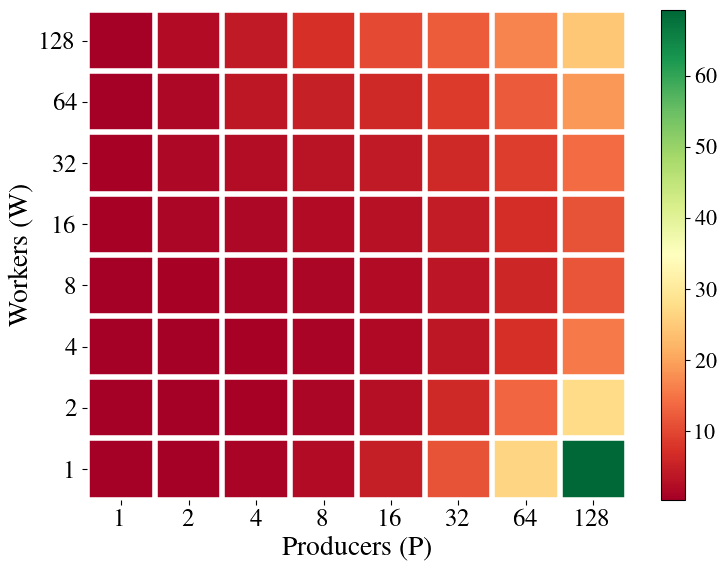

/tmp/ipykernel_3367115/3159724921.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base = mpl.cm.get_cmap(base_name, n)


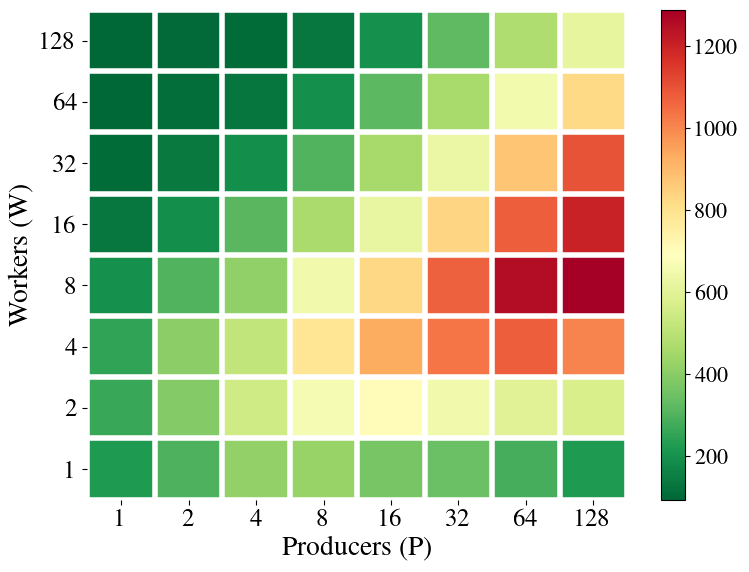

Saved heatmaps to: /mnt/home/zwshi/learned-index/cost-model/include/FALCON/results/log/figs


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from pathlib import Path

plt.rcParams.update({
                "text.usetex": True,
                "font.family": "serif",
                "font.serif": ["Times", "Computer Modern Roman"],
                "axes.unicode_minus": False,
                "text.latex.preamble": r"\usepackage{amsmath}",
            })
    
def truncated_cmap(base_name="cividis", minval=0.05, maxval=0.75, n=256, reverse=False):
    base = mpl.cm.get_cmap(base_name, n)
    colors = base(np.linspace(minval, maxval, n))
    if reverse:
        colors = colors[::-1]  # 关键：反转截断后的颜色，而不是用 base_name+"_r" 再截断
    return mpl.colors.LinearSegmentedColormap.from_list(
        f"{base_name}_trunc_{minval:.2f}_{maxval:.2f}_{'r' if reverse else 'f'}",
        colors
    )
    
    
def heatmap_from_pivot(pivot: pd.DataFrame, title: str, outpath: Path, fmt=None, higher_is_better=True, scale=1):
    """
    pivot: index=workers (y), columns=producers (x)
    """
    # Ensure numeric and sorted axes
    pivot = pivot.sort_index().sort_index(axis=1)
    pivot = pivot/scale
    x = pivot.columns.to_numpy()
    y = pivot.index.to_numpy()
    Z = pivot.to_numpy()
    nrows, ncols = Z.shape
    # cmap = "RdYlGn"
    cmap = "RdYlGn"
    if higher_is_better:
        cmap = truncated_cmap(cmap, minval=0.0, maxval=1.0, reverse=True)
    else:
        cmap = truncated_cmap(cmap, minval=0.0, maxval=1.0, reverse=False)
    fig, ax = plt.subplots(figsize=(8, 6))
    # im = ax.imshow(Z, aspect="auto", origin="lower",cmap=cmap, extent=(-0.5, ncols-0.5, -0.5, nrows-0.5),)
    # im.set_rasterized(True)
    X, Y = np.meshgrid(np.arange(ncols+1), np.arange(nrows+1))
    im = ax.pcolormesh(
        X - 0.5, Y - 0.5, Z,
        cmap=cmap,
        shading="flat",
        edgecolors="white",
        linewidth=1.2
    )
    # ax.set_title(title)
    ax.set_xlabel(r"Producers (P)",fontsize=20)
    ax.set_ylabel(r"Workers (W)",fontsize=20)

    ax.set_xlim(-0.5, ncols-0.5)
    ax.set_ylim(-0.5, nrows-0.5)
    ax.set_xticks(np.arange(-0.5, len(x), 1), minor=True)
    ax.set_yticks(np.arange(-0.5, len(y), 1), minor=True)
    ax.grid(which="minor", color="white", linestyle="-", linewidth=4)
    ax.tick_params(which="minor", bottom=False, left=False)
    ax.set_xticks(np.arange(len(x)))
    ax.set_xticklabels(x,fontsize=18)
    ax.set_yticks(np.arange(len(y)))
    ax.set_yticklabels(y,fontsize=18)

    cbar = fig.colorbar(im, ax=ax)
    # cbar.ax.set_ylabel(title, rotation=90, fontsize=20)
    # for s in cbar.ax.spines.values():
    #     s.set_visible(False)
    # Optional: annotate each cell (useful for small grids like 5x8)
    # if fmt is not None:
    #     for i in range(len(y)):
    #         for j in range(len(x)):
    #             val = Z[i, j]
    #             if np.isfinite(val):
    #                 ax.text(j, i, fmt.format(val), ha="center", va="center", fontsize=12, color="white")
    for spine in ax.spines.values():
        spine.set_visible(False)
    fig.tight_layout()
    plt.show()
    fig.savefig(outpath, dpi=200)
    plt.close(fig)

def main(csv_path: str, out_dir: str = "figs_heatmap", agg="mean"):
    csv_path = Path(csv_path)
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)

    df = pd.read_csv(csv_path)

    # 强制类型
    int_cols = ["producers", "workers"]
    for c in int_cols:
        df[c] = df[c].astype(int)

    needed = ["latency_ns", "wall_time_ns", "hit_ratio", "data_IO_time_ns", "avg_IOs"]
    missing = [c for c in needed if c not in df.columns]
    if missing:
        raise ValueError(f"Missing columns in CSV: {missing}")

    queries_total = 1000000  # e.g., 1000000
    if queries_total is not None:
        df["throughput_qps"] = queries_total / (df["wall_time_ns"] * 1e-9)
    else:
        # 退化方案：画 1 / wall_time (越大越好)，当作相对吞吐指标
        df["throughput_rel"] = 1.0 / df["wall_time_ns"]

    # 聚合 repeats：按 (P,W) 聚合
    if agg == "median":
        g = df.groupby(["workers", "producers"], as_index=False).median(numeric_only=True)
    else:
        g = df.groupby(["workers", "producers"], as_index=False).mean(numeric_only=True)

    # 1) Wall time heatmap（秒）
    # wall_pivot = g.pivot(index="workers", columns="producers", values="wall_time_ns") / 1e9
    # heatmap_from_pivot(
    #     wall_pivot,
    #     title=r"Wall Time (s)",
    #     outpath=out_dir / "heatmap_wall_time_s.pdf",
    #     fmt="{:.2f}"
    # )

    # 2) Avg latency heatmap（ms）
    lat_pivot = g.pivot(index="workers", columns="producers", values="latency_ns") / 1e6
    heatmap_from_pivot(
        lat_pivot,
        title=r"Query Latency (ms)",
        outpath=out_dir / "heatmap_latency_ms.pdf",
        fmt="{:.2f}",
        higher_is_better=False
    )

    # 3) Throughput heatmap（相对：1/wall_time）
    if "throughput_qps" in g.columns:
        thr_pivot = g.pivot(index="workers", columns="producers", values="throughput_qps")
        heatmap_from_pivot(
            thr_pivot,
            title=r"Throughput (KQPS)",
            outpath=out_dir / "heatmap_throughput_qps.pdf",
            fmt="{:.0f}",
            scale = 1000
        )
    else:
        thr_pivot = g.pivot(index="workers", columns="producers", values="throughput_rel")
        heatmap_from_pivot(
            thr_pivot,
            title="Relative Throughput (1 / wall_time_ns)",
            outpath=out_dir / "heatmap_throughput_rel.pdf",
            fmt="{:.2e}"
        )

    print(f"Saved heatmaps to: {out_dir.resolve()}")

main("./books_200M_uint64_unique_falcon_grid2.csv","./figs/","mean")



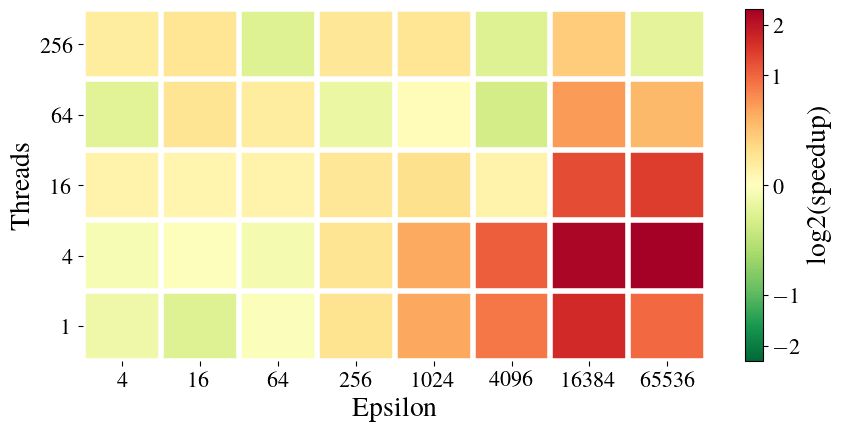

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm,SymLogNorm,FuncNorm


plt.rcParams.update({
                "text.usetex": True,
                "font.family": "serif",
                "font.serif": ["Times", "Computer Modern Roman"],
                "axes.unicode_minus": False,
                "text.latex.preamble": r"\usepackage{amsmath}",
            })
# -----------------------------
# Input data (from your table)
# -----------------------------
speedup_by_eps = {
    4: {
        1:   0.978947685,
        4:   0.995011151,
        16:  1.015437423,
        64:  0.949420297,
        256: 1.034110879,
    },
    16: {
        1:   0.938566401,
        4:   0.999669008,
        16:  1.012983985,
        64:  1.065643157,
        256: 1.057751552,
    },
    64: {
        1:   0.998403308,
        4:   0.989634904,
        16:  1.017153905,
        64:  1.036794195,
        256: 0.938671465,
    },
    256: {
        1:   1.07458416,
        4:   1.067055186,
        16:  1.055683412,
        64:  0.972951394,
        256: 1.056933598,
    },
    1024: {
        1:   1.391594012,
        4:   1.383339233,
        16:  1.085337057,
        64:  1.00113907,
        256: 1.05907693,
    },
    4096: {
        1:   1.789116185,
        4:   2.094711033,
        16:  1.017416164,
        64:  0.902525443,
        256: 0.937634357,
    },
    16384: {
        1:   3.191012859,
        4:   4.781814015,
        16:  2.389452827,
        64:  1.485357749,
        256: 1.173039249,
    },
    65536: {
        1:   1.958982214,
        4:   5.160004959,
        16:  2.665851494,
        64:  1.279736753,
        256: 0.958922183,
    },
}

# -----------------------------
# 2) Build pivot table: rows=threads, cols=epsilon
# -----------------------------
threads = sorted({t for eps in speedup_by_eps for t in speedup_by_eps[eps].keys()})
epsilons = sorted(speedup_by_eps.keys())

speedup = pd.DataFrame(
    [[speedup_by_eps[eps].get(t, np.nan) for eps in epsilons] for t in threads],
    index=threads,
    columns=epsilons,
)
speedup.index.name = "threads"
speedup.columns.name = "epsilon"

Z = speedup.to_numpy()
logZ = np.log2(Z)
max_abs = np.nanmax(np.abs(logZ))
# vmin2, vmax2 = np.nanmin(logZ), np.nanmax(logZ)
# norm2 = TwoSlopeNorm(vmin=-max_abs, vcenter=0.0, vmax=max_abs)
gamma = 0.55  # 0.4~0.8 之间常用；越小越强调0附近、越压缩极端

def forward(x):
    x = np.asarray(x)
    return np.sign(x) * (np.abs(x) / max_abs) ** gamma

def inverse(y):
    y = np.asarray(y)
    return np.sign(y) * (np.abs(y) ** (1 / gamma)) * max_abs

norm2 = FuncNorm((forward, inverse), vmin=-max_abs, vmax=max_abs)

fig, ax = plt.subplots(figsize=(9.0, 4.6))
nrows, ncols = logZ.shape
# im = ax.imshow(logZ, origin="lower", aspect="auto", cmap="RdBu_r", norm=norm2)
X, Y = np.meshgrid(np.arange(ncols+1), np.arange(nrows+1))
im = ax.pcolormesh(
    X - 0.5, Y - 0.5, logZ,
        cmap="RdYlGn_r",
        shading="flat",
        edgecolors="white",
        linewidth=1.2,
        norm=norm2
    )

ax.set_xlim(-0.5, ncols-0.5)
ax.set_ylim(-0.5, nrows-0.5)
ax.set_xticks(np.arange(-0.5, ncols, 1), minor=True)
ax.set_yticks(np.arange(-0.5, nrows, 1), minor=True)
ax.grid(which="minor", color="white", linestyle="-", linewidth=4)
ax.tick_params(which="minor", bottom=False, left=False)

ax.set_xticks(np.arange(len(epsilons)))
ax.set_xticklabels(epsilons)
ax.set_yticks(np.arange(len(threads)))
ax.set_yticklabels(threads)

ax.set_xlabel(r"Epsilon",fontsize=20)
ax.set_ylabel(r"Threads",fontsize=20)

for spine in ax.spines.values():
    spine.set_visible(False)
cbar = fig.colorbar(im, ax=ax)
cbar.set_label(r"log2(speedup)",fontsize=20)

fig.tight_layout()
fig.savefig("./figs/speedup_log2_heatmap.pdf", dpi=300, bbox_inches="tight")
plt.show()